# Stellar interior model

Importamos las librerías necesarias para el código y escribimos la configuración básica que se sigue en la presentación de los resultados.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats


pd.set_option('display.max_rows',None)   # Ver los DataFrames completos
plt.rcParams.update({'font.family':'Calibri'})  # Cambiamos el tipo de fuente

from matplotlib.ticker import FixedLocator
from matplotlib.ticker import AutoMinorLocator


###  Auxiliar Functions

In [2]:
def energia(T,P,X,Y):
    """ 
    Calculate the energy production based on the local conditions.
    
    The function decides what is the predominant reaction (pp or CN).
    
    Parameters
    ---------- 
    T : Temperature. Input float.
    P : Pressure. Input float.
    X : Mass fraction of hydrogen.
    Y : Mass fraction of helium.
    
    Returns
    -------
    reac : It is a string. It says which type of reaction has been chosen.
        If reac is '--' it means there is no energy production.
    nu,e : Parameters to calculate the energy production in our conditions.
    """
    
    # Cálculo de la densidad
    Z=1-X-Y
    mu = 1/(2*X+0.75*Y+0.5*Z)
    H = 1/6.02214076e+23    # [g]
    boltz = 1.380649e-23    # [J/K]
    rho = mu*H/boltz*(P*10e8)/(T*10e7)
    
    # Rangos de temperatura
    # Cadena pp
    if T < 0.4:
        nu_pp = 0
        e_pp = 0
    elif T < 0.6:
        nu_pp = 6
        e_pp = 10**-6.84
    elif T < 0.95:
        nu_pp = 5
        e_pp = 10**-6.04
    elif T < 1.2:
        nu_pp = 4.5
        e_pp = 10**-5.56
    elif T < 1.65:
        nu_pp = 4
        e_pp = 10**-5.02
    elif T < 2.4:
        nu_pp = 3.5
        e_pp = 10**-4.40
    else:
        nu_pp = 0
        e_pp = 0
    
    # Ciclo CN
    if T < 1.2:
        nu_cn = 0
        e_cn = 0
    elif T < 1.6:
        nu_cn = 20
        e_cn = 10**-22.2
    elif T < 2.25:
        nu_cn = 18
        e_cn = 10**-19.8
    elif T < 2.75:
        nu_cn = 16
        e_cn = 10**-17.1
    elif T < 3.6:
        nu_cn = 15
        e_cn = 10**-15.6
    elif T < 5.0:
        nu_cn = 13
        e_cn = 10**-12.5
    else:
        nu_cn = 0
        e_cn= 0
        
    Epp = e_pp*(X**2)*rho*((T*10)**nu_pp)
    Ecn = e_cn*X*Z/3*rho*((T*10)**nu_cn)
    cual = (Ecn < Epp)      # Qué reacción domina?
    if cual == True:
        reac = 'pp'
        nu = nu_pp
        e = e_pp
    else:
        reac = 'CN'
        nu = nu_cn
        e = e_cn
    if e_pp==0:        # Se produce energía?
        reac = '--'
    return (reac,nu,e)


def FaseRad(X,Y,M_tot,R_tot,L_tot):
    """
    Calculate the boundary of the radiative part of the star.
    
    It makes an interpolation to find the expected values of radius, mass, pressure, luminosity and temperature at the point where the convective part starts.
    
    Parameters
    ----------
    X : mass fraction of hydrogen.
    Y : mass fraction of helium.
    M_tot : mass of the star.
    R_tot : radius of the star.
    L_tot : luminosity of the star.
    
    Returns
    -------
    h : step in radius.
    front : boundary layer.
    r_front : radius at the boundary.
    M_front : mass at the boundary.
    P_front : pressure at the boundary.
    L_front : luminosity at the boundary.
    T_front : temperature at the boundary.
    
    First values are usefull for FaseConv function.
    """
    # Inicialización de las variables
    R_in = 0.90*R_tot  # evitamos problemas de convergencia
    Z = 1-X-Y
    mu = 1/(2*X+0.75*Y+0.5*Z)   # Peso mulecular medio cte.
    n_capa = 101   # Número de capas en las que se va a dividir el radio
    
    #Inicializamos los vectores para guardar las variables
    capa = np.arange(0,n_capa,1)
    r = np.linspace(R_in,0,n_capa)
    M = np.zeros(n_capa)
    P = np.zeros(n_capa)
    L = np.zeros(n_capa)
    T = np.zeros(n_capa)
    N = np.zeros(n_capa)
    # Inicializamos las f_i para integración
    fm = np.zeros(n_capa)
    fp = np.zeros(n_capa)
    fl = np.zeros(n_capa)
    ft = np.zeros(n_capa)
    
    h = r[0]-r[1]   # Paso de integración
    
    # Capas superficiales (L=cte y M=cte)
    for i in range(3):
        M[i] = M_tot
        L[i] = L_tot
        T[i] = (1.9022*mu*M_tot)*(1/r[i]-1/R_tot)      # Se usa R_tot
        P[i] = (10.645*np.sqrt(M_tot/(mu*Z*(1+X)*L_tot)))*T[i]**4.25    
        # f para método diferencias (fm=fl=0 -> ctes). Caso radiativo
        ft[i] = -(0.01679*Z*(1+X)*mu**2)*(P[i]**2)*L[i]/((T[i]**8.5)*r[i]**2)
        fp[i] = -(8.084*mu)*P[i]*M_tot/(T[i]*r[i]**2)
        
    # Integración desde la superficie
    i = 2   # Las tres primeras capas ya están calculadas.
    N[i] = T[i]/P[i]*fp[i]/ft[i]  # Cálculo inicial de n+1
    
    if N[i]<=2.5:   # Comprobamos que las primeras capas sean radiativas
        raise NotImplementedError('La parte superficial de la estrella no es radiativa!')
    
    while N[i]>2.5:   # Capas radiativas hasta la frontera convectiva
        # Cálculo de las Delta_P[i] y Delta_T[i]
        DP1 = -h*fp[i]+h*fp[i-1]
        DP2 = -h*fp[i]+2*h*fp[i-1]-h*fp[i-2]
        DT1 = -h*ft[i]+h*ft[i-1]    # h es negativo
        # Cálculo P_est y T_est
        P_est = P[i]-h*fp[i]+(DP1/2)+(5/12*DP2)
        T_est = T[i]-h*ft[i]+DT1/2
        P_old = P[i]
        T_old = T[i]
        
        while abs((T_est-T_old)/T_est) > 0.0001:
            while abs((P_est-P_old)/P_est) > 0.0001:
                # Masa calculada
                fm[i+1] = 0.01523*mu*P_est*(r[i+1]**2)/T_est
                DM1 = -h*fm[i+1]+h*fm[i]    # Delta_M[i+1]
                M[i+1] = M[i]-h*fm[i+1]-DM1/2        
                #Presión calculada a partir de la anterior masa
                fp[i+1] = -(8.084*mu)*P_est/T_est*M[i+1]/(r[i+1]**2)
                DP1 = -h*fp[i+1]+h*fp[i]    # Delta_P[i+1]
                P[i+1] = P[i]-h*fp[i+1]-DP1/2  
                P_old = P_est
                P_est = P[i+1]
            
            # Producción energía
            t_reac,nu,e = energia(T_est,P[i+1],X,Y)    # Factores producción energía
            if t_reac == 'pp':
                fl[i+1] = 0.01845*e*(X**2)*(10**nu)*(mu**2)*(P[i+1]**2)*(T_est**(nu-2))*r[i+1]**2        
            elif t_reac =='CN':
                fl[i+1] = 0.01845*e*X*Z/3*(10**nu)*(mu**2)*(P[i+1]**2)*(T_est**(nu-2))*r[i+1]**2
            else:
                fl[i+1] = 0            
            # Luminosidad calculada
            DL1 = -h*fl[i+1]+h*fl[i]
            DL2 = -h*fl[i+1]+2*h*fl[i]-h*fl[i-1]
            L[i+1] = L[i]-h*fl[i+1]-(DL1/2)-(DL2/12)        
            # Temperatura calculada a partir de todo lo demás
            ft[i+1] = -0.01679*Z*(1+X)*mu**2*(P[i+1]**2)*(L[i+1])/((T_est**8.5)*r[i+1]**2)
            DT1 = -h*ft[i+1]+h*ft[i]
            T[i+1] = T[i]-h*ft[i+1]-DT1/2        
            T_old = T_est
            T_est = T[i+1]
            
        i+=1    # Contador
        if i > (n_capa-1):      # Para poner un límite al bucle while
            break

        N[i] = T[i]*fp[i]/(P[i]*ft[i])
        if N[i] <= 2.5:
            front = i    # Marcador del frontera radiativa
    # La última capa no es radiativa
    
    # INTERPOLACIÓN. Parte radiativa. Acortamos vectores a los dos últimos valores
    r = np.flip(r[front-1:front+1])
    M = np.flip(M[front-1:front+1])
    P = np.flip(P[front-1:front+1])
    L = np.flip(L[front-1:front+1])
    T = np.flip(T[front-1:front+1])
    N = np.flip(N[front-1:front+1])
    
    # Interpolamos valores de los parámetros para la capa n+1=2.5
    r_front = np.interp(2.5,N,r)
    M_front = np.interp(2.5,N,M)
    P_front = np.interp(2.5,N,P)
    L_front = np.interp(2.5,N,L)
    T_front = np.interp(2.5,N,T)
    
    return (h,front,r_front,M_front,P_front,L_front,T_front)


def FaseConv(X,Y,h,front,Tc,r_front,P_rad=0,T_rad=1):
    """
    Calculate the star parameters for the boundary layer of convection. It is based on an initial temperature which has to be given.
    
    Parameters
    ----------
    X : mass fraction of hydrogen.
    Y : mass fraction of helium.
    h : step in raidus. It has been computed in FaseRad function.
    front : boundary layer between radiation and convection. Also computed.
    Tc : central temperature of our star.
    r_front : expected radius on the boundary. Calculated in FaseRad.
    P_rad,T_rad : estimated pressure and temperature from radiative part on the boundary.
        It is used for calculate the constant K for the polytropic model of pressure. The default value is K=0.
        
    
    Returns
    -------
    M_front : mass at the boundary.
    P_front : preassure at the boundary.
    L_front : luminosity at the boundary.
    T_front : temperature at the boundary.   
    """
    
    # Inicialización de variables
    Z = 1-X-Y
    mu = 1/(2*X+0.75*Y+0.5*Z)
    K = P_rad/(T_rad**2.5)   # Polítropo
    
    # Inicialización de los vectores
    r = np.arange(0,r_front+1.1*h,h)   # Necesitamos un punto más allá de la frontera para interpolar
    M = np.zeros(len(r))
    P = np.zeros(len(r))
    L = np.zeros(len(r))
    T = np.zeros(len(r))
    # Inicializamos las f_i para método Predictor-Corrector
    fm = np.zeros(len(r))
    fl = np.zeros(len(r))
    ft = np.zeros(len(r))
    
    # Capa central (Mc=Lc=0). Calculamos las tres capas centrales
    for i in range(3):      # Tres capas centrales
        # Cálculo de los parámetros
        M[i] = 0.005077*mu*K*(Tc**1.5)*r[i]**3
        T[i] = Tc-0.008207*(mu**2)*K*(Tc**1.5)*r[i]**2
        P[i] = K*(T[i]**2.5)
        # Produción energía
        t_reac,nu,e = energia(Tc,P[0],X,Y)
        if t_reac == 'pp':
            L[i] = 0.00615*e*X**2*(10**nu)*mu**2*K**2*(Tc**(3+nu))*r[i]**3
        elif t_reac == 'CN':
            L[i] = 0.00615*e*X*Z/3*(10**nu)*mu**2*K**2*(Tc**(3+nu))*r[i]**3
        else:
            if i == 0:
                L[0] = 0
            else:
                L[i] = L[i-1]            
        # f para método diferencias
        fm[i] = 0.01523*mu*K*(T[i]**1.5)*(r[i]**2)   
        if r[i] != 0:    
            ft[i] = 3.234*mu*M[i]/(r[i]**2)     # en r=0 no se puede evaluar f[t]
        if t_reac == 'pp':
            fl[i] = 0.01845*e*X*X*(10**nu)*mu**2*K**2*(T[i]**(nu+3))*r[i]**2
        elif t_reac =='CN':
            fl[i] = 0.01845*e*X*Z/3*(10**nu)*mu**2*K**2*(T[i]**(nu+3))*r[i]**2
        else:
            fl[i] = 0
        
    # Integración desde el centro
    for i in range(2,len(r)-1):   # Las tres primeras capas ya están calculadas
        # Estimación de temperatura.
        DT1 = h*ft[i]-h*ft[i-1]
        T_est = T[i]+h*ft[i]+DT1/2
        T_old = T[i]
    
        while abs((T_est-T_old)/T_est) > 0.0001:
            # Presión estimada (polítropo) y masa calculada
            P_est = K*(T_est**2.5)
            fm[i+1] = 0.01523*mu*P_est*r[i+1]**2/T_est
            DM1 = h*fm[i+1]-h*fm[i]
            M[i+1] = M[i]+h*fm[i+1]-DM1/2
            # Cálculo de la nueva temperatura
            ft[i+1] = -3.234*mu*M[i+1]/r[i+1]**2
            DT1 = h*ft[i+1]-h*ft[i]
            T[i+1] = T[i]+h*ft[i+1]-DT1/2       
            T_old = T_est 
            T_est = T[i+1]
        
        P[i+1] = K*(T[i+1]**2.5)
        # Producción energía
        t_reac,nu,e = energia(T[i+1],P[i+1],X,Y)
        if t_reac == 'pp':
            fl[i+1] = 0.01845*e*X*X*(10**nu)*mu**2*(P[i+1]**2)*(T[i+1]**(nu-2))*r[i+1]**2
        elif t_reac == 'CN':
            fl[i+1] = 0.01845*e*X*Z/3*(10**nu)*mu**2*(P[i+1]**2)*(T[i+1]**(nu-2))*r[i+1]**2
        else:
            fl[i+1] = 0  
        # Cálculo de la luminosidad
        DL1 = h*fl[i+1]-h*fl[i]
        DL2 = h*fl[i+1]-2*h*fl[i]+h*fl[i-1]
        L[i+1] = L[i]+h*fl[i+1]-(DL1/2)-(DL2/12)
    # La última capa no es convectiva
    
    # INTERPOLACIÓN. Fase convectiva. Acortamos los vectores a los dos últimos valores
    r = r[len(T)-2:len(T)]
    M = M[len(T)-2:len(T)]
    P = P[len(T)-2:len(T)]
    L = L[len(T)-2:len(T)]
    T = T[len(T)-2:len(T)]
    
    # Interpolamos los valores de los parámetros para la capa n+1=2.5
    M_front = np.interp(r_front,r,M)
    P_front = np.interp(r_front,r,P)
    L_front = np.interp(r_front,r,L)
    T_front = np.interp(r_front,r,T)
    
    return(M_front,P_front,L_front,T_front)


def Find_Tc(X,Y,M_tot,R_tot,L_tot,Tc_in):
    """
    This function tries to find what is the better central temperature for a given star.
    
    It is based on the shooting method to couple both solutions (convective and radiative) in the boundry layer.
    
    Parameters
    ----------
    X : mass fraction of hydrogen.
    Y : mass fraction of helium.
    M_tot : mass of the star.
    R_tot : radius of the star.
    L_tot : luminosity of the star.
    Tc_in : initial value for central temperature.
    
    Returns
    -------
    Tc : best central temperature.
    Err_min : relative error for Tc (the minimun found).
    Tc_vect : (Array) A vector of different values for Tc.
    Err_vect : (Array) Errors for Tc_vect.
    """
    
    # Cálculo de las capas exteriores
    (h,frontera,R,M_r,P_r,L_r,T_r) = FaseRad(X,Y,M_tot,R_tot,L_tot)
    
    # Con los datos calculamos la parte central variando Tc
    Tc = np.arange(Tc_in-0.5,Tc_in+0.5,0.1)
    Err = np.ones(len(Tc))
    
    for i in range(len(Tc)):
        M_c,P_c,L_c,T_c = FaseConv(X,Y,h,frontera,Tc[i],R,P_r,T_r)
        Err[i] = np.sqrt(((M_r-M_c)/M_r)**2+((P_r-P_c)/P_r)**2+((L_r-L_c)/L_r)**2+((T_r-T_c)/T_r)**2)

    i_min = np.where(Err == min(Err))[0]
    
    # Control por si i_min está en extremos
    if i_min == 0:
        i_min = 1
    if i_min == (len(Tc)-1):
        i_min -= 1
    
    Tc = np.arange(Tc[i_min-1],Tc[i_min+1],abs(Tc[i_min-1]-Tc[i_min+1])/10)
    Err = np.ones(len(Tc))

    for i in range(len(Tc)):
        M_c,P_c,L_c,T_c = FaseConv(X,Y,h,frontera,Tc[i],R,P_r,T_r)
        Err[i] = np.sqrt(((M_r-M_c)/M_r)**2+((P_r-P_c)/P_r)**2+((L_r-L_c)/L_r)**2+((T_r-T_c)/T_r)**2)


    i_min = np.where(Err == min(Err))[0]
    
    # Control por si i_min está en extremos
    if i_min == 0:
        i_min = 1
    if i_min == (len(Tc)-1):
        i_min -= 1
    
    Tc = np.arange(Tc[i_min-1],Tc[i_min+1],abs(Tc[i_min-1]-Tc[i_min+1])/10)
    Err = np.ones(len(Tc))

    for i in range(len(Tc)):
        M_c,P_c,L_c,T_c = FaseConv(X,Y,h,frontera,Tc[i],R,P_r,T_r)
        Err[i] = np.sqrt(((M_r-M_c)/M_r)**2+((P_r-P_c)/P_r)**2+((L_r-L_c)/L_r)**2+((T_r-T_c)/T_r)**2)

    
    i_min = np.where(Err == min(Err))[0]
    
    # Control por si i_min está en extremos
    if i_min == 0:
        i_min = 1
    if i_min == (len(Tc)-1):
        i_min -= 1
    
    Tc = np.arange(Tc[i_min-1],Tc[i_min+1],abs(Tc[i_min-1]-Tc[i_min+1])/10)
    Err = np.ones(len(Tc))

    for i in range(len(Tc)):
        M_c,P_c,L_c,T_c = FaseConv(X,Y,h,frontera,Tc[i],R,P_r,T_r)
        Err[i] = np.sqrt(((M_r-M_c)/M_r)**2+((P_r-P_c)/P_r)**2+((L_r-L_c)/L_r)**2+((T_r-T_c)/T_r)**2)


    i_min = np.where(Err == min(Err))[0]
    
    # Control por si i_min está en extremos
    if i_min == 0:
        i_min = 1
    if i_min == (len(Tc)-1):
        i_min -= 1
    
    Tc = np.arange(Tc[i_min-1],Tc[i_min+1],abs(Tc[i_min-1]-Tc[i_min+1])/10)
    Err = np.ones(len(Tc))

    for i in range(len(Tc)):
        M_c,P_c,L_c,T_c = FaseConv(X,Y,h,frontera,Tc[i],R,P_r,T_r)
        Err[i] = np.sqrt(((M_r-M_c)/M_r)**2+((P_r-P_c)/P_r)**2+((L_r-L_c)/L_r)**2+((T_r-T_c)/T_r)**2)

    
    i_min = np.where(Err == min(Err))[0]
    
    Tc = Tc[i_min]
    Err_min = Err[i_min]
    
    return (Tc,Err_min)
    
    
    

### Stellar-interior numerical model

Introducimos los parámetros de nuestra estrella en particular

In [3]:
X = 0.75
Y = 0.20
M_tot = 5.0

# Valores iniciales
R_in = 12.0
L_in = 40.0
Tc_in = 1.5

Buscamos los valores apropiados de radio, luminosidad y temperatura central para la estrella mediante el método del disparo con un "zoom iterativo".

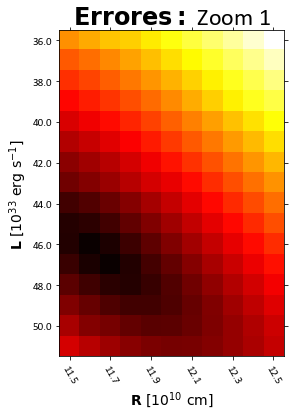

In [4]:
# Introduciomos un vector con los valores deseados para probar L y R
delta_L = 1.0
delta_R = 0.1

L_vect = np.arange(35.0,50.0+0.1*delta_L,delta_L)
R_vect = np.arange(11.5,12.5+0.1*delta_R,delta_R)

# Creamos un array para almacenar los distintos errores relativos
# L eje y // R eje x
Err_array = np.ones([len(L_vect),len(R_vect)])
Tc_array = Err_array*0

# Recorremos los valores para rellenar los arrays
for i in range(len(L_vect)):   # Para cada L
    for j in range(len(R_vect)):   # Para cada R
        Tc_array[i,j], Err_array[i,j] = Find_Tc(X,Y,M_tot,R_vect[j],L_vect[i],Tc_in)

# Dibujamos los errores mínimos encontrados en función del radio y la luminosidad
zoom = 1

# Preparamos los ejes
L_ax = []
R_ax = []
for i in range(len(L_vect)):
    if i%2 != 0:
        L_ax.append(L_vect[i])
for i in range(len(R_vect)):
    if i%2 == 0:
        R_ax.append(R_vect[i])

# Figura Zoom 1
fig,ax = plt.subplots(figsize=(7,6))
ax.imshow(Err_array,cmap='hot')
ax.set_title(r'$\mathbf{Errores:} $ Zoom '+str(zoom),fontsize=24)
ax.set_xlabel(r'$\mathbf{R} \ [10^{10} \ \rm{cm}]$',fontsize=14)
ax.set_ylabel(r'$\mathbf{L} \ [10^{33} \ \rm{erg \ s^{-1}}]$',fontsize=14)
ax.set_xticks(np.arange(0,11,2))
ax.set_yticks(np.arange(0,16,2))
ax.set_xticklabels(np.round(R_ax,1))
ax.set_yticklabels(np.round(L_ax,0))
ax.tick_params(axis='both',which='major',labelsize=11)
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(axis='x',labelrotation=-60)
plt.show()



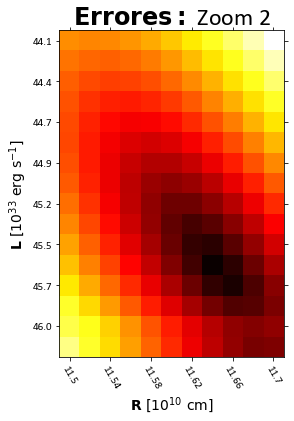

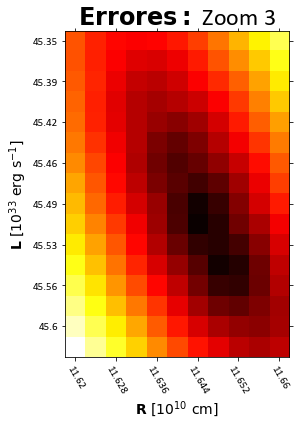

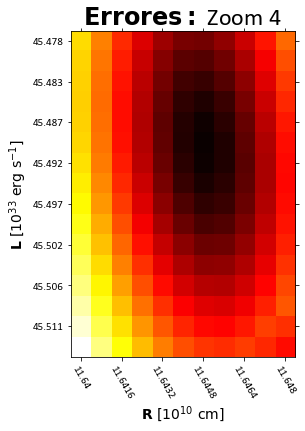

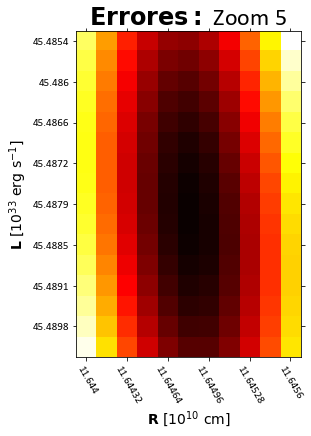

In [5]:
# Asignamos nuevos valores para L_in y R_in
Emin = np.zeros(len(L_vect))
jmin = np.zeros(len(L_vect))

for i in range(len(L_vect)):   #Buscamos el mínimo error en la fila
    Emin[i] = min(Err_array[i,:])
    jmin[i] = np.where(Err_array[i,:]==Emin[i])[0]
I = int(np.where(Emin==min(Emin))[0])  # Posición del mínimo de L
J = int(jmin[I])   # Posición del mínimo de R

# Reducimos el paso en L y R
L_vect = np.linspace(L_vect[I-1],L_vect[I+1],len(L_vect))
delta_L = abs(L_vect[0]-L_vect[1])
R_vect = np.linspace(R_vect[J-1],R_vect[J+1],len(R_vect))
delta_R = abs(R_vect[0]-R_vect[1])

# Recorremos los valores para rellenar los arrays
for i in range(len(L_vect)):   # Para cada L
    for j in range(len(R_vect)):   # Para cada R
        Tc_array[i,j], Err_array[i,j] = Find_Tc(X,Y,M_tot,R_vect[j],L_vect[i],Tc_in)

# Dibujamos los errores mínimos encontrados en función del radio y la luminosidad
zoom += 1

# Preparamos los ejes
L_ax = []
R_ax = []
for i in range(len(L_vect)):
    if i%2 != 0:
        L_ax.append(L_vect[i])
for i in range(len(R_vect)):
    if i%2 == 0:
        R_ax.append(R_vect[i])


# Figura Zoom 2
fig,ax = plt.subplots(figsize=(7,6))
ax.imshow(Err_array,cmap='hot')
ax.set_title(r'$\mathbf{Errores:} $ Zoom '+str(zoom),fontsize=24)
ax.set_xlabel(r'$\mathbf{R} \ [10^{10} \ \rm{cm}]$',fontsize=14)
ax.set_ylabel(r'$\mathbf{L} \ [10^{33} \ \rm{erg \ s^{-1}}]$',fontsize=14)
ax.set_xticks(np.arange(0,11,2))
ax.set_yticks(np.arange(0,16,2))
ax.set_xticklabels(np.round(R_ax,2))
ax.set_yticklabels(np.round(L_ax,1))
ax.tick_params(axis='both',which='major',labelsize=11)
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(axis='x',labelrotation=-60)
plt.show()        


###############################

# Asignamos nuevos valores para L_in y R_in
Emin = np.zeros(len(L_vect))
jmin = np.zeros(len(L_vect))

for i in range(len(L_vect)):   #Buscamos el mínimo error en la fila
    Emin[i] = min(Err_array[i,:])
    jmin[i] = np.where(Err_array[i,:]==Emin[i])[0]
I = int(np.where(Emin==min(Emin))[0])  # Posición del mínimo de L
J = int(jmin[I])   # Posición del mínimo de R

# Reducimos el paso en L y R
L_vect = np.linspace(L_vect[I-1],L_vect[I+1],len(L_vect))
delta_L = abs(L_vect[0]-L_vect[1])
R_vect = np.linspace(R_vect[J-1],R_vect[J+1],len(R_vect))
delta_R = abs(R_vect[0]-R_vect[1])

# Recorremos los valores para rellenar los arrays
for i in range(len(L_vect)):   # Para cada L
    for j in range(len(R_vect)):   # Para cada R
        Tc_array[i,j], Err_array[i,j] = Find_Tc(X,Y,M_tot,R_vect[j],L_vect[i],Tc_in)

# Dibujamos los errores mínimos encontrados en función del radio y la luminosidad
zoom += 1

# Preparamos los ejes
L_ax = []
R_ax = []
for i in range(len(L_vect)):
    if i%2 != 0:
        L_ax.append(L_vect[i])
for i in range(len(R_vect)):
    if i%2 == 0:
        R_ax.append(R_vect[i])


# Figura Zoom 3
fig,ax = plt.subplots(figsize=(7,6))
ax.imshow(Err_array,cmap='hot')
ax.set_title(r'$\mathbf{Errores:} $ Zoom '+str(zoom),fontsize=24)
ax.set_xlabel(r'$\mathbf{R} \ [10^{10} \ \rm{cm}]$',fontsize=14)
ax.set_ylabel(r'$\mathbf{L} \ [10^{33} \ \rm{erg \ s^{-1}}]$',fontsize=14)
ax.set_xticks(np.arange(0,11,2))
ax.set_yticks(np.arange(0,16,2))
ax.set_xticklabels(np.round(R_ax,3))
ax.set_yticklabels(np.round(L_ax,2))
ax.tick_params(axis='both',which='major',labelsize=11)
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(axis='x',labelrotation=-60)
plt.show()        


###############################

# Asignamos nuevos valores para L_in y R_in
Emin = np.zeros(len(L_vect))
jmin = np.zeros(len(L_vect))

for i in range(len(L_vect)):   #Buscamos el mínimo error en la fila
    Emin[i] = min(Err_array[i,:])
    jmin[i] = np.where(Err_array[i,:]==Emin[i])[0]
I = int(np.where(Emin==min(Emin))[0])  # Posición del mínimo de L
J = int(jmin[I])   # Posición del mínimo de R

# Reducimos el paso en L y R
L_vect = np.linspace(L_vect[I-1],L_vect[I+1],len(L_vect))
delta_L = abs(L_vect[0]-L_vect[1])
R_vect = np.linspace(R_vect[J-1],R_vect[J+1],len(R_vect))
delta_R = abs(R_vect[0]-R_vect[1])

# Recorremos los valores para rellenar los arrays
for i in range(len(L_vect)):   # Para cada L
    for j in range(len(R_vect)):   # Para cada R
        Tc_array[i,j], Err_array[i,j] = Find_Tc(X,Y,M_tot,R_vect[j],L_vect[i],Tc_in)

# Dibujamos los errores mínimos encontrados en función del radio y la luminosidad
zoom += 1

# Preparamos los ejes
L_ax = []
R_ax = []
for i in range(len(L_vect)):
    if i%2 != 0:
        L_ax.append(L_vect[i])
for i in range(len(R_vect)):
    if i%2 == 0:
        R_ax.append(R_vect[i])


# Figura Zoom 4
fig,ax = plt.subplots(figsize=(7,6))
ax.imshow(Err_array,cmap='hot')
ax.set_title(r'$\mathbf{Errores:} $ Zoom '+str(zoom),fontsize=24)
ax.set_xlabel(r'$\mathbf{R} \ [10^{10} \ \rm{cm}]$',fontsize=14)
ax.set_ylabel(r'$\mathbf{L} \ [10^{33} \ \rm{erg \ s^{-1}}]$',fontsize=14)
ax.set_xticks(np.arange(0,11,2))
ax.set_yticks(np.arange(0,16,2))
ax.set_xticklabels(np.round(R_ax,4))
ax.set_yticklabels(np.round(L_ax,3))
ax.tick_params(axis='both',which='major',labelsize=11)
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(axis='x',labelrotation=-60)
plt.show()        


###############################

# Asignamos nuevos valores para L_in y R_in
Emin = np.zeros(len(L_vect))
jmin = np.zeros(len(L_vect))

for i in range(len(L_vect)):   #Buscamos el mínimo error en la fila
    Emin[i] = min(Err_array[i,:])
    jmin[i] = np.where(Err_array[i,:]==Emin[i])[0]
I = int(np.where(Emin==min(Emin))[0])  # Posición del mínimo de L
J = int(jmin[I])   # Posición del mínimo de R

# Reducimos el paso en L y R
L_vect = np.linspace(L_vect[I-1],L_vect[I+1],len(L_vect))
delta_L = abs(L_vect[0]-L_vect[1])
R_vect = np.linspace(R_vect[J-1],R_vect[J+1],len(R_vect))
delta_R = abs(R_vect[0]-R_vect[1])

# Recorremos los valores para rellenar los arrays
for i in range(len(L_vect)):   # Para cada L
    for j in range(len(R_vect)):   # Para cada R
        Tc_array[i,j], Err_array[i,j] = Find_Tc(X,Y,M_tot,R_vect[j],L_vect[i],Tc_in)

# Dibujamos los errores mínimos encontrados en función del radio y la luminosidad
zoom += 1

# Preparamos los ejes
L_ax = []
R_ax = []
for i in range(len(L_vect)):
    if i%2 != 0:
        L_ax.append(L_vect[i])
for i in range(len(R_vect)):
    if i%2 == 0:
        R_ax.append(R_vect[i])


# Figura Zoom 5
fig,ax = plt.subplots(figsize=(7,6))
ax.imshow(Err_array,cmap='hot')
ax.set_title(r'$\mathbf{Errores:} $ Zoom '+str(zoom),fontsize=24)
ax.set_xlabel(r'$\mathbf{R} \ [10^{10} \ \rm{cm}]$',fontsize=14)
ax.set_ylabel(r'$\mathbf{L} \ [10^{33} \ \rm{erg \ s^{-1}}]$',fontsize=14)
ax.set_xticks(np.arange(0,11,2))
ax.set_yticks(np.arange(0,16,2))
ax.set_xticklabels(np.round(R_ax,5))
ax.set_yticklabels(np.round(L_ax,4))
ax.tick_params(axis='both',which='major',labelsize=11)
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(axis='x',labelrotation=-60)
plt.show()        



In [6]:
# Asignamos los valores encontrados para segir con los cálculos

Error_relat = Err_array[I,J]
Tc = Tc_array[I,J]
L_tot = L_vect[I]
R_tot = R_vect[J]

parametros = pd.DataFrame({
    'X':[X],
    'Y':[Y],
    'M$_{tot}$':[M_tot],
    'R$_{tot}$': [R_tot],
    'L$_{tot}$':[L_tot],
    'T$_c$':[Tc]
})

Vamos a obtener todos los datos de nuestra estrella para los valores recién encontrados.

In [7]:
# Inicialización de las variables necesarias

R_in = 0.90*R_tot
Z = 1-X-Y       # Metalicidad

mu = 1/(2*X+0.75*Y+0.5*Z)   # Peso mulecular medio cte.
n_capa = 101   # Número de capas en las que se va a dividir el radio

# Inicializamos los vectores de las variables para caso radiat.
reac = ['--' for i in range(n_capa)]
fase = ['Superficie' for i in range(n_capa)]
capa = np.arange(0,n_capa,1)

r = np.linspace(R_in,0,n_capa)
M = np.zeros(n_capa)
P = np.zeros(n_capa)
L = np.zeros(n_capa)
T = np.zeros(n_capa)

N = np.zeros(n_capa)

# Inicializamos las f_i para método Predictor-Corrector
fm = np.zeros(n_capa)
fp = np.zeros(n_capa)
fl = np.zeros(n_capa)
ft = np.zeros(n_capa)

h = r[0]-r[1]   # Paso de integración
cota_err = 0.0001

##############################################################################

# INTEGRACIÓN DESDE LA SUPERFICIE

##############################################################################

for i in range(3):      # Cálculo de las tres capas más superficiales
    M[i] = M_tot
    L[i] = L_tot
    T[i] = (1.9022*mu*M_tot)*(1/r[i]-1/R_tot)      # Se usa R_tot
    P[i] = (10.645*np.sqrt(M_tot/(mu*Z*(1+X)*L_tot)))*T[i]**4.25
    
    # f para método diferencias (fm=fl=0 -> ctes). Caso radiativo
    ft[i] = -(0.01679*Z*(1+X)*mu**2)*(P[i]**2)*L[i]/((T[i]**8.5)*r[i]**2)
    fp[i] = -(8.084*mu)*P[i]*M_tot/(T[i]*r[i]**2)

##############################################################################

# FASE RADIATIVA. Integración desde superficie

i = 2   # Las tres primeras capas ya están calculadas.
N[i] = T[i]/P[i]*fp[i]/ft[i]  # Cálculo inicial de n+1
if N[i] <= 2.5:
    raise ValueError('Las capas superficiales no son radiativas!')

while N[i] > 2.5:       # Capas radiativas hasta la frontera radiativa
    
    # Cálculo de las Delta_P[i] y Delta_T[i]
    DP1 = -h*fp[i]+h*fp[i-1]
    DP2 = -h*fp[i]+2*h*fp[i-1]-h*fp[i-2]
    DT1 = -h*ft[i]+h*ft[i-1]    # h es negativo
    # Cálculo P_est y T_est
    P_est = P[i]-h*fp[i]+(DP1/2)+(5/12*DP2)
    T_est = T[i]-h*ft[i]+DT1/2
    P_old = P[i]
    T_old = T[i]
    
    while abs((T_est-T_old)/T_est) > cota_err:
        while abs((P_est-P_old)/P_est) > cota_err:
            
            # Masa calculada
            fm[i+1] = 0.01523*mu*P_est*(r[i+1]**2)/T_est
            DM1 = -h*fm[i+1]+h*fm[i]    # Delta_M[i+1]
            M[i+1] = M[i]-h*fm[i+1]-DM1/2
            
            #Presión calculada a partir de la anterior masa
            fp[i+1] = -(8.084*mu)*P_est/T_est*M[i+1]/(r[i+1]**2)
            DP1 = -h*fp[i+1]+h*fp[i]    # Delta_P[i+1]
            P[i+1] = P[i]-h*fp[i+1]-DP1/2
            
            P_old = P_est
            P_est = P[i+1]
        
        # Producción energía
        t_reac,nu,e = energia(T_est,P[i+1],X,Y)    # Factores producción energía
        if t_reac == 'pp':
            fl[i+1] = 0.01845*e*(X**2)*(10**nu)*(mu**2)*(P[i+1]**2)*(T_est**(nu-2))*r[i+1]**2        
        elif t_reac =='CN':
            fl[i+1] = 0.01845*e*X*Z/3*(10**nu)*(mu**2)*(P[i+1]**2)*(T_est**(nu-2))*r[i+1]**2
        else:
            fl[i+1] = 0
            
        # Luminosidad calculada
        DL1 = -h*fl[i+1]+h*fl[i]
        DL2 = -h*fl[i+1]+2*h*fl[i]-h*fl[i-1]
        L[i+1] = L[i]-h*fl[i+1]-(DL1/2)-(DL2/12)
        
        # Temperatura calculada a partir de todo lo demás
        ft[i+1] = -0.01679*Z*(1+X)*mu**2*(P[i+1]**2)*(L[i+1])/((T_est**8.5)*r[i+1]**2)
        DT1 = -h*ft[i+1]+h*ft[i]
        T[i+1] = T[i]-h*ft[i+1]-DT1/2
        
        T_old = T_est
        T_est = T[i+1]
    i+=1    # Contador
    if i > (n_capa-1):      # Para poner un límite al bucle while
        print('Todas las capas son radiativas.')
        break

    N[i] = T[i]*fp[i]/(P[i]*ft[i])

    if N[i] <= 2.5:
        frontera = i    # Marcador del frontera radiativa

    reac[i] = t_reac
    fase[i] = 'Tr. Radiat'

# Este bucle recoge una capa que no es radiativa.

K = P[frontera]/(T[frontera]**2.5)  # Modelo de polítropo para capas convectivas

# Eliminamos la capa extra
M[frontera] = 0     # !!!
P[frontera] = 0
L[frontera] = 0
T[frontera] = 0

##############################################################################

# INTEGRACIÓN DESDE EL CENTRO

##############################################################################

# Inicialización de las variables necesarias para las capas convectivas

r_conv = np.arange(0,r[frontera]+0.1*h,h)

M_conv = np.zeros(len(r_conv))
P_conv = np.zeros(len(r_conv))
L_conv = np.zeros(len(r_conv))
T_conv = np.zeros(len(r_conv))

##############################################################################

# CAPAS INICIALES. Fase convectiva con M y L =0

for i in range(3):      # Tres capas centrales
    # Cálculo de los parámetros
    M_conv[i] = 0.005077*mu*K*(Tc**1.5)*r_conv[i]**3
    T_conv[i] = Tc-0.008207*(mu**2)*K*(Tc**1.5)*r_conv[i]**2
    P_conv[i] = K*(T_conv[i]**2.5)
    
    # Produción energía
    t_reac,nu,e = energia(Tc,P_conv[0],X,Y)
    if t_reac == 'pp':
        L_conv[i] = 0.00615*e*X**2*(10**nu)*mu**2*K**2*(Tc**(3+nu))*r_conv[i]**3
    elif t_reac == 'CN':
        L_conv[i] = 0.00615*e*X*Z/3*(10**nu)*mu**2*K**2*(Tc**(3+nu))*r_conv[i]**3
    else:
        if i == 0:
            L_conv[0] = 0
        else:
            L_conv[i] = L_conv[i-1]
            
    # f para método diferencias
    fm[i] = 0.01523*mu*K*(T_conv[i]**1.5)*(r_conv[i]**2)   
    if r_conv[i] != 0:    
        ft[i] = 3.234*mu*M_conv[i]/(r_conv[i]**2)     # en r=0 no se puede evaluar f[t]
    if t_reac == 'pp':
        fl[i] = 0.01845*e*X*X*(10**nu)*mu**2*K**2*(T_conv[i]**(nu+3))*r_conv[i]**2
    elif t_reac =='CN':
        fl[i] = 0.01845*e*X*Z/3*(10**nu)*mu**2*K**2*(T_conv[i]**(nu+3))*r_conv[i]**2
    else:
        fl[i] = 0
    
    fase[n_capa-1-i] = 'Centro'
    reac[n_capa-1-i] = t_reac

##############################################################################
    
# FASE CONVECTIVA. Integración desde el centro.

for i in range(2,len(r_conv)-1):
    
    # Estimación de temperatura.
    DT1 = h*ft[i]-h*ft[i-1]
    T_est = T_conv[i]+h*ft[i]+DT1/2
    T_old = T_conv[i]
    
    while abs((T_est-T_old)/T_est) > cota_err:
        # Presión estimada (polítropo) y masa calculada
        P_est = K*(T_est**2.5)
        fm[i+1] = 0.01523*mu*P_est*r_conv[i+1]**2/T_est
        DM1 = h*fm[i+1]-h*fm[i]
        M_conv[i+1] = M_conv[i]+h*fm[i+1]-DM1/2
        
        # Cálculo de la nueva temperatura
        ft[i+1] = -3.234*mu*M_conv[i+1]/r_conv[i+1]**2
        DT1 = h*ft[i+1]-h*ft[i]
        T_conv[i+1] = T_conv[i]+h*ft[i+1]-DT1/2
        
        T_old = T_est 
        T_est = T_conv[i+1]
    
    P_conv[i+1] = K*(T_conv[i+1]**2.5)
    # Producción energía
    t_reac,nu,e = energia(T_conv[i+1],P_conv[i+1],X,Y)
    if t_reac == 'pp':
        fl[i+1] = 0.01845*e*X*X*(10**nu)*mu**2*(P_conv[i+1]**2)*(T_conv[i+1]**(nu-2))*r_conv[i+1]**2
    elif t_reac == 'CN':
        fl[i+1] = 0.01845*e*X*Z/3*(10**nu)*mu**2*(P_conv[i+1]**2)*(T_conv[i+1]**(nu-2))*r_conv[i+1]**2
    else:
        fl[i+1] = 0
    
    # Cálculo de la luminosidad
    DL1 = h*fl[i+1]-h*fl[i]
    DL2 = h*fl[i+1]-2*h*fl[i]+h*fl[i-1]
    L_conv[i+1] = L_conv[i]+h*fl[i+1]-(DL1/2)-(DL2/12)
    
    fase[n_capa-2-i] = 'Tr. Convect'
    reac[n_capa-2-i] = t_reac

    
##############################################################################

# CAPAS SUPERFICIALES OMITIDAS

##############################################################################

r_superf = np.concatenate((np.arange(R_in+h,R_tot,h),R_tot),axis=None)

M_superf = np.ones(len(r_superf))*M_tot
L_superf = np.ones(len(r_superf))*L_tot
T_superf = np.zeros(len(r_superf))
P_superf = np.zeros(len(r_superf))

for i in range(len(r_superf)):
    T_superf[i] = (1.9022*mu*M_tot)*(1/r_superf[i]-1/R_tot)
    P_superf[i] = (10.645*np.sqrt(M_tot/(L_in*mu*Z*(1+X))))*T_superf[i]**4.25
    

reac_sup = ['--' for i in range(len(r_superf))]
fase_sup = ['Omit.' for i in range(len(r_superf))]
i_sup = np.ones(len(r_superf))*float('NaN')


##############################################################################

# AGRUPACIÓN de resultados
# La parte convectiva está del revés

M[frontera:] = np.flip(M_conv)
P[frontera:] = np.flip(P_conv)
L[frontera:] = np.flip(L_conv)
T[frontera:] = np.flip(T_conv)

r = np.concatenate((np.flip(r_superf),r),axis=None)
M = np.concatenate((M_superf,M),axis=None)
L = np.concatenate((L_superf,L),axis=None)
P = np.concatenate((np.flip(P_superf),P),axis=None)
T = np.concatenate((np.flip(T_superf),T),axis=None)
reac = np.concatenate((reac_sup,reac),axis=None)
fase = np.concatenate((fase_sup,fase),axis=None)
capa = np.concatenate((i_sup,capa),axis=None)



Calculamos la densidad ($\rho$), la generación de energía ($\varepsilon$) y la opacidad ($\kappa$). Todas estas cantidades están normalizadas.

In [8]:
# Densidad con gases ideales
dens = np.zeros(len(r))   # Problema convergencia
for i in range(1,len(r)):
    dens[i] = P[i]/T[i]   # Va normalizada   
dens /= max(dens)

# Generación energía
eps = np.zeros(len(r))
dif = 0.01
lim_eps = 109
for i in range(1,len(eps)-1):
    if dens[i] == 0:
        eps[i] = 0  # Solucionamos convergencia. Si no hay densidad no ha energia
    else:
        x = [r[i-1],r[i],r[i+1]]
        y = [L[i-1],L[i],L[i+1]]
        interp = np.polyfit(x,y,deg=2)   # Función orden 2 con ptos cercanos 
        derL = (np.polyval(interp,r[i]+dif/2)-np.polyval(interp,r[i]-dif/2))/dif   # Diferencias centradas
        eps[i] = derL/(dens[i]*r[i]**2)
        if i > lim_eps:
            eps[i] = eps[i-1]  # Límite central
eps[len(r)-1] = eps[len(r)-2]      
eps /= max(eps)
        
# Opacidad
opac = np.zeros(len(r))
for i in range(1,len(opac)):
    opac[i] = dens[i]/(T[i]**3.5)
opac /= max(opac)



### Results

Escribimos los parámetros encontrados para nuestra estrella.

In [9]:
display(parametros)
print('El mínimo error relativo encontrado es del', np.round(Error_relat*100,4),'%')
T_eff = (1/(4*np.pi*5.670374419e-8)*(L_tot*1e10)/(R_tot)**2)**(1/4)   # Teniendo en cuenta la unidiades. Devuelve en K
print('T_eff =',int(T_eff),'K')

,X,Y,M$_{tot}$,R$_{tot}$,L$_{tot}$,T$_c$
0,0.75,0.2,5.0,11.64496,45.486617,1.85712


El mínimo error relativo encontrado es del 0.0383 %
T_eff = 8283 K


Agrupamos y presentamos todos los datos obtenidos.

In [10]:
Data = pd.DataFrame({
    'Capa': capa,
    'Reacción': reac,
    'Fase': fase,
    'R [$10^{10}$ cm]': r,
    'P [$10^{15}$ din cm$^{-2}$]': P,
    'T [$10^7$ K]': T,
    'L [$10^{33}$ erg s$^{-1}$]': L,
    'M [$10^{33}$ g]': M,
    '$\rho$ [Norm.]': np.round(dens,3),
    '$\epsilon$ [Norm.]': np.round(eps,3),
    '$\kappa$ [Norm.]': np.round(opac,4)
    })

display(Data)

,Capa,Reacción,Fase,R [$10^{10}$ cm],P [$10^{15}$ din cm$^{-2}$],T [$10^7$ K],L [$10^{33}$ erg s$^{-1}$],M [$10^{33}$ g],$\rho$ [Norm.],$\epsilon$ [Norm.],$\kappa$ [Norm.]
0,NaN,--,Omit.,11.644960,0.000000e+00,0.000000,45.486617,5.000000,0.000,0.000,0.0000
1,NaN,--,Omit.,11.633315,1.389193e-13,0.000488,45.486617,5.000000,0.000,0.000,1.0000
2,NaN,--,Omit.,11.528510,2.567239e-09,0.004925,45.486617,5.000000,0.000,0.000,0.5611
3,NaN,--,Omit.,11.423706,4.083433e-08,0.009444,45.486617,5.000000,0.000,0.000,0.4768
4,NaN,--,Omit.,11.318901,2.206764e-07,0.014046,45.486617,5.000000,0.000,0.000,0.4318
5,NaN,--,Omit.,11.214096,7.505186e-07,0.018735,45.486617,5.000000,0.000,0.000,0.4018
6,NaN,--,Omit.,11.109292,1.970408e-06,0.023512,45.486617,5.000000,0.000,0.000,0.3796
7,NaN,--,Omit.,11.004487,4.384016e-06,0.028379,45.486617,5.000000,0.000,0.000,0.3621
8,NaN,--,Omit.,10.899683,8.694776e-06,0.033341,45.486617,5.000000,0.000,0.000,0.3478
9,NaN,--,Omit.,10.794878,1.584708e-05,0.038399,45.486617,5.000000,0.000,0.000,0.3358


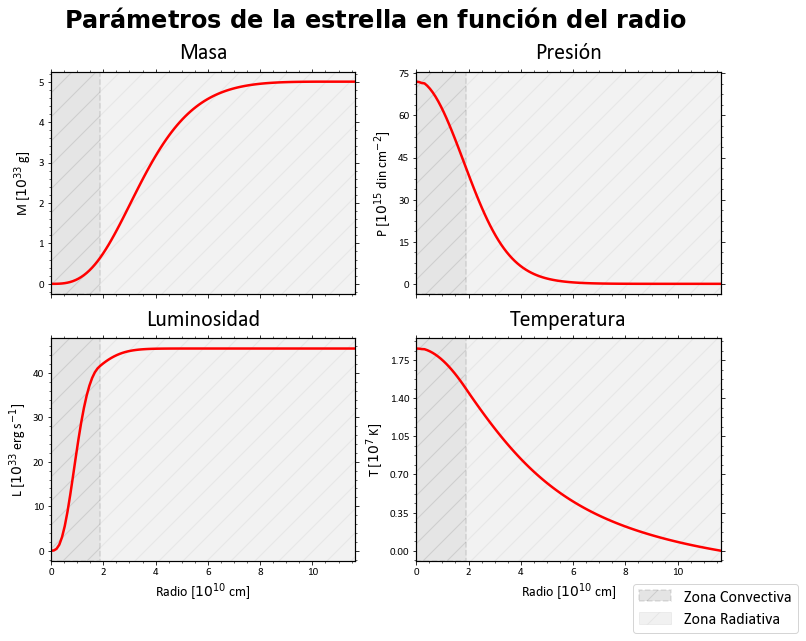

In [11]:
fig,axs = plt.subplots(2,2,figsize=(12,9))

fig.suptitle('$\mathbf{Parámetros \ de \ la \ estrella \ en \ función \ del \ radio}$',fontsize=24)
for ax in axs.flat:
    ax.tick_params(bottom=True,top=True,left=True,right=True)
    ax.set_xlim([0,R_tot])
    ax.spines[['bottom','left','top','right']].set_linewidth(1.2)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor',bottom=True,top=True,left=True,right=True)
    ax.tick_params(axis='both',which='major',labelsize=11)


axs[0,0].plot(r,M,'r',linewidth=2.5)
axs[0,0].set_title('Masa',y=1.03,fontsize=22)
axs[0,0].set_ylabel('M [$10^{33}$ g]',fontsize=14)
axs[0,0].axvspan(0,r[int(np.where(Data['Capa']==frontera)[0])],color='black',alpha=0.1,linewidth=1.5,label='Zona Convectiva',hatch='/',linestyle='--')  # Zona convectiva
axs[0,0].axvspan(r[int(np.where(Data['Capa']==frontera)[0])],R_tot,color='gray',alpha=0.1,label='Zona Radiativa',hatch='/',linestyle='-')  # Zona radiativa
axs[0,0].tick_params(labelbottom=False)


axs[0,1].plot(r,P,'r',linewidth=2.5)
axs[0,1].set_title('Presión',y=1.03,fontsize=22)
axs[0,1].set_ylabel('P [$10^{15}$ din cm$^{-2}$]',fontsize=14)
axs[0,1].axvspan(0,r[int(np.where(Data['Capa']==frontera)[0])],color='black',alpha=0.1,hatch='/',linestyle='--',linewidth=1.5)  # Zona convectiva
axs[0,1].axvspan(r[int(np.where(Data['Capa']==frontera)[0])],R_tot,color='gray',alpha=0.1,hatch='/')  # Zona radiativa
axs[0,1].tick_params(labelbottom=False)
axs[0,1].yaxis.set_major_locator(FixedLocator(np.linspace(0,75,6)))


axs[1,0].plot(r,L,'r',linewidth=2.5)
axs[1,0].set_title('Luminosidad',y=1.03,fontsize=22)
axs[1,0].set_ylabel('L [$10^{33}$ erg s$^{-1}$]',fontsize=14)
axs[1,0].set_xlabel('Radio [$10^{10}$ cm]',fontsize=14)
axs[1,0].axvspan(0,r[int(np.where(Data['Capa']==frontera)[0])],color='black',alpha=0.1,hatch='/',linestyle='--',linewidth=1.5)  # Zona convectiva
axs[1,0].axvspan(r[int(np.where(Data['Capa']==frontera)[0])],R_tot,color='gray',alpha=0.1,hatch='/')  # Zona radiativa


axs[1,1].plot(r,T,'r',linewidth=2.5)
axs[1,1].set_title('Temperatura',y=1.03,fontsize=22)
axs[1,1].set_ylabel('T [$10^{7}$ K]',fontsize=14)
axs[1,1].set_xlabel('Radio [$10^{10}$ cm]',fontsize=14)
axs[1,1].axvspan(0,r[int(np.where(Data['Capa']==frontera)[0])],color='black',alpha=0.1,hatch='/',linestyle='--',linewidth=1.5)  # Zona convectiva
axs[1,1].axvspan(r[int(np.where(Data['Capa']==frontera)[0])],R_tot,color='gray',alpha=0.1,hatch='/')  # Zona radiativa
axs[1,1].yaxis.set_major_locator(FixedLocator(np.linspace(0,2.1,7)))


fig.legend(loc=4,fontsize=16)
plt.show()

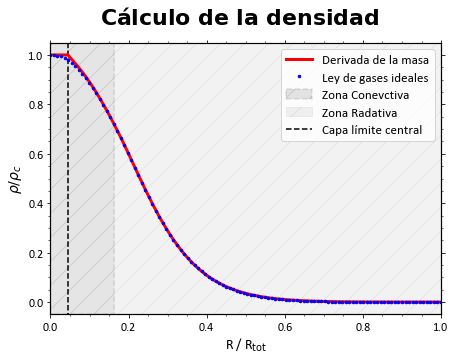

In [42]:
# Cálculo de la densidad derivando la masa
r_norm = r/R_tot

# Derivando la masa
rho = np.zeros(len(r))
for i in range(1,len(r)-1):
    x = [r[i-1],r[i],r[i+1]]
    y = [M[i-1],M[i],M[i+1]]
    interp = np.polyfit(x,y,deg=2)   # Función orden 2 con ptos cercanos 
    derM = (np.polyval(interp,r[i]+dif/2)-np.polyval(interp,r[i]-dif/2))/dif   # Diferencias centradas
    rho[i] = derM/r[i]**2   # Va normalizada
    if i > 107:   # Capa límite (inestabilidad en el centro)
        rho[i] = rho[i-1]
rho[len(r)-1] = rho[len(r)-2]  # Evitamos que calcule la densidad en el centro
rho /= max(rho)

fig,ax = plt.subplots(figsize=(7,5))
fig.suptitle('$\mathbf{Cálculo \ de \ la \ densidad}$',fontsize=22)

ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.spines[['bottom','left','top','right']].set_linewidth(1.2)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor',bottom=True,top=True,left=True,right=True)
ax.tick_params(axis='both',which='major',labelsize=12)
ax.set_xlim([0,1])
ax.set_ylim([-0.05,1.05])

ax.plot(r_norm,rho,'r',label='Derivada de la masa',linewidth=3)
ax.plot(r_norm,dens,'.b',label='Ley de gases ideales',markersize=5)
ax.set_ylabel(r'$\rho / \rho_c $',fontsize=14)
ax.set_xlabel('R / R$_{\mathrm{tot}}$',fontsize=14)
ax.axvspan(0,r_norm[int(np.where(Data['Capa']==frontera)[0])],color='black',alpha=0.1,hatch='/',linestyle='--',linewidth=1.5,label='Zona Conevctiva')  # Zona convectiva
ax.axvspan(r_norm[int(np.where(Data['Capa']==frontera)[0])],1,color='gray',alpha=0.1,hatch='/',label='Zona Radativa')  # Zona radiativa
ax.vlines(r_norm[107],ymin=-1,ymax=2,color='k',linestyle='--',label='Capa límite central')

ax.legend(fontsize=13)

plt.show()

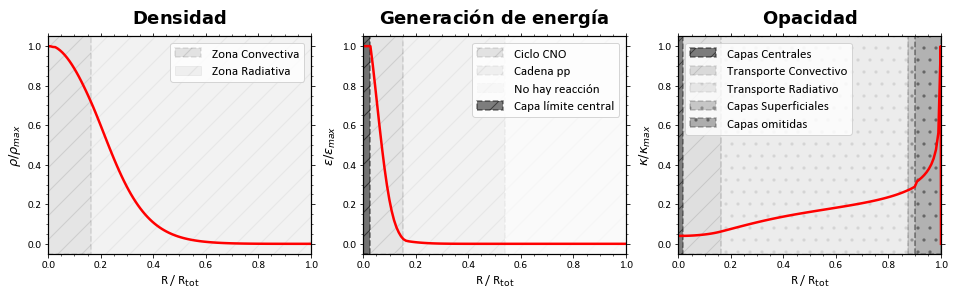

In [13]:
fig,axs = plt.subplots(1,3,figsize=(16,4))

for ax in axs.flat:
    ax.set_xlim([0,1])
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(bottom=True,top=True,left=True,right=True)
    ax.tick_params(which='minor',bottom=True,top=True,left=True,right=True)
    ax.spines[['bottom','left','top','right']].set_linewidth(1.2)
    ax.tick_params(axis='both',which='major',labelsize=11)

axs[0].plot(r_norm,dens,'r',linewidth=2.5)
axs[0].set_title(r'$\mathbf{Densidad}$',y=1.03,fontsize=18)
axs[0].set_ylabel(r'$ \rho / \rho_{max} $',fontsize=13)
axs[0].set_xlabel('R / R$_{\mathrm{tot}}$',fontsize=13)
axs[0].axvspan(0,r_norm[int(np.where(Data['Capa']==frontera)[0])],label='Zona Convectiva',color='black',alpha=0.1,hatch='/',linestyle='--',linewidth=1.5)
axs[0].axvspan(r_norm[int(np.where(Data['Capa']==frontera)[0])],1,label='Zona Radiativa',color='gray',alpha=0.1,hatch='/')
axs[0].legend(fontsize=13)


axs[1].plot(r_norm,eps,'r',linewidth=2.5)
axs[1].set_title(r'$\mathbf{Generación \ de \ energía}$',y=1.03,fontsize=18)
axs[1].set_ylabel(r'$ \varepsilon / \varepsilon _{max} $',fontsize=13)
axs[1].set_xlabel('R / R$_{\mathrm{tot}}$',fontsize=13)
axs[1].axvspan(0,max(r_norm[np.where(Data['Reacción']=='CN')[0]]),label='Ciclo CNO',color='black',alpha=0.1,linestyle='--',hatch='/',linewidth=1.5)
axs[1].axvspan(max(r_norm[np.where(Data['Reacción']=='CN')[0]]),max(r_norm[np.where(Data['Reacción']=='pp')[0]]),label='Cadena pp',color='gray',alpha=0.1,linestyle='--',hatch='/',linewidth=1.5)
axs[1].axvspan(max(r_norm[np.where(Data['Reacción']=='pp')[0]]),1,label='No hay reacción',color='lightgray',alpha=0.1,linestyle='--',hatch='/')
axs[1].axvspan(0,r_norm[lim_eps],label='Capa límite central',color='black',alpha=0.5,linestyle='--',linewidth=1.5,hatch='/')
axs[1].legend(fontsize=13)


axs[2].plot(r_norm,opac,'r',linewidth=2.5)
axs[2].set_title(r'$\mathbf{Opacidad}$',y=1.03,fontsize=18)
axs[2].set_ylabel(r'$ \kappa / \kappa _{max} $',fontsize=13)
axs[2].set_xlabel('R / R$_{\mathrm{tot}}$',fontsize=13)
axs[2].axvspan(0,max(r_norm[np.where(Data['Fase']=='Centro')]),color='black',alpha=0.5,label='Capas Centrales',linestyle='--',linewidth=1.5,hatch='/')
axs[2].axvspan(max(r_norm[np.where(Data['Fase']=='Centro')]),max(r_norm[np.where(Data['Fase']=='Tr. Convect')]),color='gray',alpha=0.25,label='Transporte Convectivo',linestyle='--',linewidth=1.5,hatch='/')
axs[2].axvspan(max(r_norm[np.where(Data['Fase']=='Tr. Convect')]),max(r_norm[np.where(Data['Fase']=='Tr. Radiat')]),color='gray',alpha=0.15,label='Transporte Radiativo',linestyle='--',linewidth=1.5,hatch='.')
axs[2].axvspan(max(r_norm[np.where(Data['Fase']=='Tr. Radiat')]),max(r_norm[np.where(Data['Fase']=='Superficie')]),color='black',alpha=0.2,label='Capas Superficiales',linestyle='--',linewidth=1.5,hatch='.')
axs[2].axvspan(max(r_norm[np.where(Data['Fase']=='Superficie')]),1,color='black',alpha=0.3,label='Capas omitidas',linestyle='--',hatch='.',linewidth=1.5)
axs[2].legend(loc=2,fontsize=13)

plt.show()

Valores normalizados

In [14]:
m_norm = M/max(M)
p_norm = P/max(P)
l_norm = L/max(L)
t_norm = T/max(T)


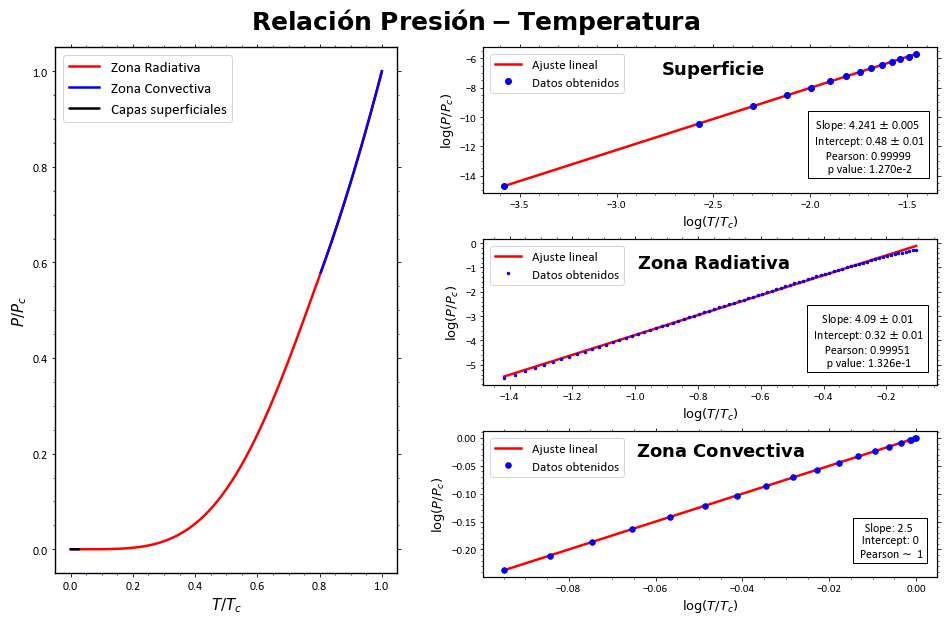

In [43]:
# Presión - Temperatura

fig = plt.figure(constrained_layout=True,figsize=(13,8))
fig.suptitle('$\mathbf{Relación \ Presión - Temperatura}$',fontsize=25,y=1.06)

subfig = fig.subfigures(1,2,wspace=0.05,width_ratios=[1,1.3])

#subfig[0].suptitle('subfig 0')
ax = subfig[0].subplots()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(which='minor',bottom=True,top=True,left=True,right=True)
ax.spines[['bottom','left','top','right']].set_linewidth(1.4)
ax.tick_params(axis='both',which='major',labelsize=12)

ax.plot(t_norm,p_norm,'r',linewidth=2.5,label='Zona Radiativa')
ax.plot(t_norm[np.where(Data['Fase']=='Tr. Convect')],p_norm[np.where(Data['Fase']=='Tr. Convect')],'b',linewidth=2.51,label='Zona Convectiva')
ax.plot(t_norm[np.where(Data['Fase']=='Centro')],p_norm[np.where(Data['Fase']=='Centro')],'b',linewidth=2.51)
ax.plot(t_norm[np.where(Data['Fase']=='Omit.')],p_norm[np.where(Data['Fase']=='Omit.')],'k',linewidth=2.51,label='Capas superficiales',solid_capstyle='round')
ax.set_xlabel(r'$T/T_{c}$',fontsize=15)
ax.set_ylabel(r'$P/P_{c}$',fontsize=15)

ax.legend(fontsize=15)


#subfig[1].suptitle('subfig 1')
axs=subfig[1].subplots(3,1)

for ax in axs.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(bottom=True,top=True,left=True,right=True)
    ax.tick_params(which='minor',bottom=True,top=True,left=True,right=True)
    ax.spines[['bottom','left','top','right']].set_linewidth(1.2)
    ax.tick_params(axis='both',which='major',labelsize=11)

# Quitamos ceros para evitar problemas
t = t_norm.copy()
t[0] = 1
p = p_norm.copy()
p[0] = 1

# Superficie
logT = np.log10(t[np.where((Data['Fase']=='Omit.') | (Data['Fase']=='Superficie'))])
logP = np.log10(p[np.where((Data['Fase']=='Omit.') | (Data['Fase']=='Superficie'))])
logT = np.delete(logT,0)
logP = np.delete(logP,0)
#axs[0].set_title('Superficie',y=1.03,fontsize=18)
axs[0].text(-2.5,-6,'$\mathbf{Superficie}$',verticalalignment='top',horizontalalignment='center',fontsize=18)
axs[0].set_ylabel(r'$\log (P/P_c) $',fontsize=13)
axs[0].set_xlabel(r'$\log (T/T_c)$',fontsize=13)

ajlin = stats.linregress(logT,logP)

axs[0].plot(logT,ajlin.intercept+logT*ajlin.slope,'r',label='Ajuste lineal',linewidth=2.5)
axs[0].plot(logT,logP,'ob',label='Datos obtenidos',markersize=6)
axs[0].legend(fontsize=13)
axs[0].text(-1.7,-10,' Slope: 4.241 $\pm$ 0.005  \n Intercept: 0.48 $\pm$ 0.01 \n Pearson: 0.99999 \n p value: 1.270e-2',fontsize=12,verticalalignment='top',horizontalalignment='center',bbox={'facecolor':'white','pad':4})


# Radiativa
logT = np.log10(t[np.where(Data['Fase']=='Tr. Radiat')])
logP = np.log10(p[np.where(Data['Fase']=='Tr. Radiat')])
#axs[1].set_title('Zona Radiativa',y=1.03,fontsize=18)
axs[1].text(-0.75,-0.4,'$\mathbf{Zona \ Radiativa}$',verticalalignment='top',horizontalalignment='center',fontsize=18)
axs[1].set_ylabel(r'$\log (P/P_c) $',fontsize=13)
axs[1].set_xlabel(r'$\log (T/T_c)$',fontsize=13)
axs[1].text(-0.26,-2.8,' Slope: 4.09 $\pm$ 0.01  \n Intercept: 0.32 $\pm$ 0.01 \n Pearson: 0.99951 \n p value: 1.326e-1',fontsize=12,verticalalignment='top',horizontalalignment='center',bbox={'facecolor':'white','pad':4})

ajlin = stats.linregress(logT,logP)

axs[1].plot(logT,ajlin.intercept+logT*ajlin.slope,'r',label='Ajuste lineal',linewidth=2.5)
axs[1].plot(logT,logP,'.b',label='Datos obtenidos',markersize=5)
axs[1].legend(fontsize=13)

#Convectiva
logT = np.log10(t[np.where((Data['Fase']=='Tr. Convect') | (Data['Fase']=='Centro'))])
logP = np.log10(p[np.where((Data['Fase']=='Tr. Convect') | (Data['Fase']=='Centro'))])
#axs[2].set_title('Convectiva',y=1.03,fontsize=18)
axs[2].text(-0.045,-0.005,'$\mathbf{Zona \ Convectiva}$',verticalalignment='top',horizontalalignment='center',fontsize=18)
axs[2].set_ylabel(r'$\log (P/P_c) $',fontsize=13)
axs[2].set_xlabel(r'$\log (T/T_c)$',fontsize=13)
axs[2].text(-0.006,-0.15,' Slope: 2.5  \n Intercept: 0 \n Pearson$\sim$ 1',fontsize=12,verticalalignment='top',horizontalalignment='center',bbox={'facecolor':'white','pad':4})

ajlin = stats.linregress(logT,logP)

axs[2].plot(logT,ajlin.intercept+logT*ajlin.slope,'r',label='Ajuste lineal',linewidth=2.5)
axs[2].plot(logT,logP,'.b',label='Datos obtenidos',markersize=11)
axs[2].legend(fontsize=13)




plt.show()

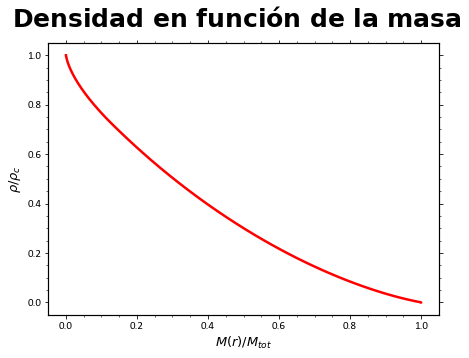

In [16]:
# Masa - densidad
fig,ax = plt.subplots(figsize=(7,5))
fig.suptitle(r'$\mathbf{Densidad \ en \ función \ de \ la \ masa}$',fontsize=25)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(which='minor',bottom=True,top=True,left=True,right=True)
ax.spines[['bottom','left','top','right']].set_linewidth(1.2)
ax.tick_params(axis='both',which='major',labelsize=11)

ax.plot(m_norm,dens,'r',linewidth=2.5)
ax.set_xlabel('$M(r)/M_{tot}$',fontsize=13)
ax.set_ylabel(r'$\rho / \rho_c$',fontsize=13)

plt.show()

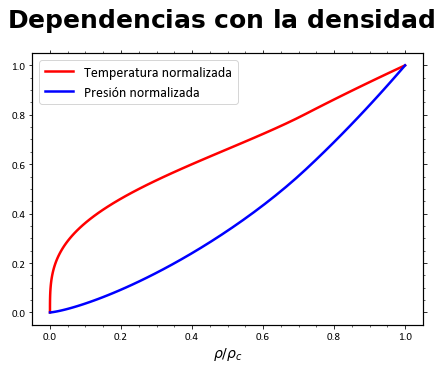

In [37]:
# Presión y temperatura con la densidad
fig,ax = plt.subplots(figsize=(7,5))
fig.suptitle(r'$\mathbf{Dependencias\ con\ la\ densidad}$',fontsize=25,y=1.01)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(which='minor',bottom=True,top=True,left=True,right=True)
ax.spines[['bottom','left','top','right']].set_linewidth(1.2)
ax.tick_params(axis='both',which='major',labelsize=11)

ax.plot(dens,t_norm,'r',linewidth=2.5,label='Temperatura normalizada')
ax.plot(dens,p_norm,'b',linewidth=2.5,label='Presión normalizada')
ax.set_xlabel(r'$\rho / \rho_c$',fontsize=14)
ax.legend(fontsize=14)
plt.show()

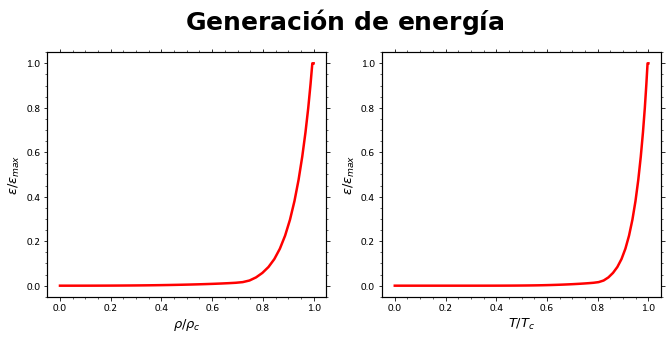

In [35]:
# Dependencias eps
fig,axs = plt.subplots(1,2,figsize=(11,4.5))
fig.suptitle(r'$\mathbf{Generación \ de \ energía}$',fontsize=25,y=1.02)

for ax in axs.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(bottom=True,top=True,left=True,right=True)
    ax.tick_params(which='minor',bottom=True,top=True,left=True,right=True)
    ax.spines[['bottom','left','top','right']].set_linewidth(1.2)
    ax.tick_params(axis='both',which='major',labelsize=11)

axs[0].plot(dens,eps,'r',linewidth=2.5)
axs[0].set_xlabel(r'$\rho / \rho_c$',fontsize=13)
axs[0].set_ylabel(r'$\epsilon / \epsilon _{max}$',fontsize=13)

axs[1].plot(t_norm,eps,'r',linewidth=2.5)
axs[1].set_xlabel(r'$T / T_c$',fontsize=13)
axs[1].set_ylabel(r'$\epsilon / \epsilon _{max}$',fontsize=13)



plt.show()

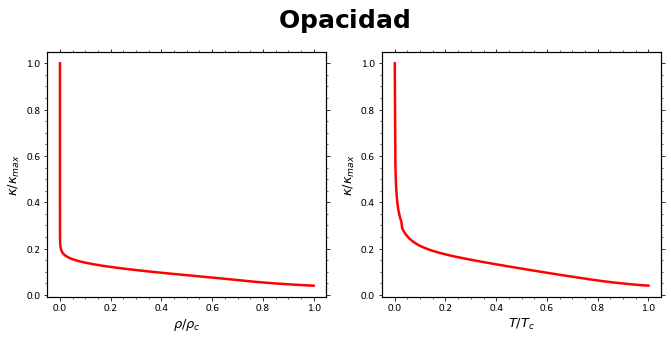

In [36]:
# Dependencias opac
fig,axs = plt.subplots(1,2,figsize=(11,4.5))
fig.suptitle(r'$\mathbf{Opacidad}$',fontsize=25,y=1.02)

for ax in axs.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(bottom=True,top=True,left=True,right=True)
    ax.tick_params(which='minor',bottom=True,top=True,left=True,right=True)
    ax.spines[['bottom','left','top','right']].set_linewidth(1.2)
    ax.tick_params(axis='both',which='major',labelsize=11)

axs[0].plot(dens[1:],opac[1:],'r',linewidth=2.5)
axs[0].set_xlabel(r'$\rho / \rho_c$',fontsize=13)
axs[0].set_ylabel(r'$\kappa / \kappa_{max}$',fontsize=13)


axs[1].plot(t_norm[1:],opac[1:],'r',linewidth=2.5)
axs[1].set_xlabel(r'$T/T_c$',fontsize=13)
axs[1].set_ylabel(r'$\kappa / \kappa_{max}$',fontsize=13)



plt.show()


#### Provisional

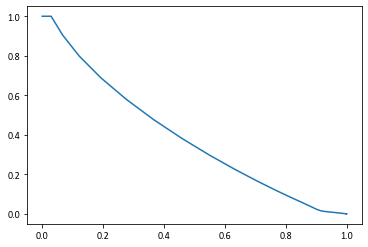

In [20]:
plt.plot(l_norm,eps)

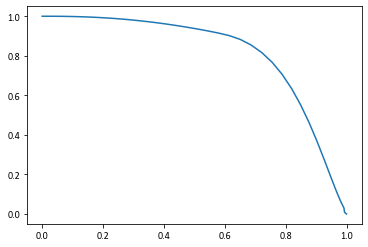

In [21]:
plt.plot(p_norm,l_norm)

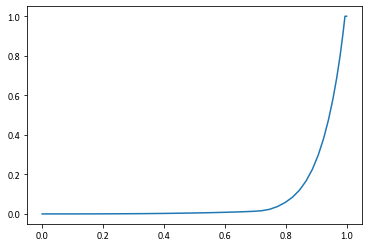

In [22]:
plt.plot(dens,eps)

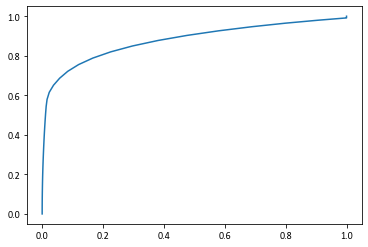

In [23]:
plt.plot(eps,p_norm)

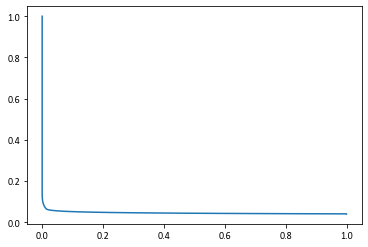

In [24]:
plt.plot(eps[1:],opac[1:])

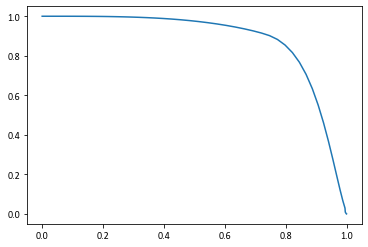

In [25]:
plt.plot(dens,l_norm)

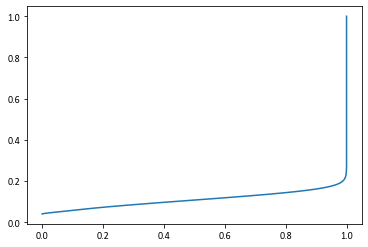

In [26]:
plt.plot(m_norm[1:],opac[1:])

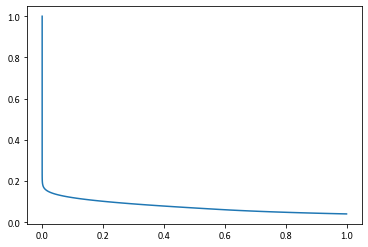

In [27]:
plt.plot(p_norm[1:],opac[1:])

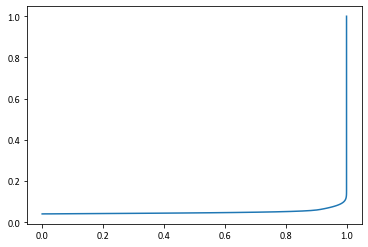

In [28]:
plt.plot(l_norm[1:],opac[1:])

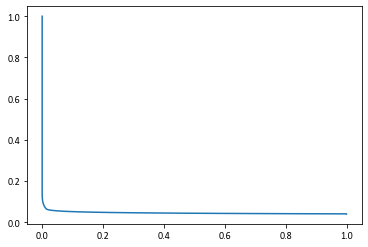

In [29]:
plt.plot(eps[1:],opac[1:])